# 1. Install Required Libraries

In [3]:
!pip install gymnasium
!pip install stable-baselines3
!pip install shimmy>=2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.4 MB/s eta 0:00:00


In [4]:
from IPython import get_ipython
from IPython.display import display

# 2. Import dependencies

In [16]:
import gym
import numpy as np
from gym import Env, spaces
from gym.spaces import Discrete, Box
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import random

# 3. Building a custom environment

In [6]:
class BaltoPuzzleEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(4)                           #0=Up, 1=Down, 2=Left, 3=Right
        self.observation_space = spaces.Box(low=0, high=1, shape=(5, 5), dtype=np.float32)
        self.state = None
        self.goal_state = np.zeros((5, 5))
        self.goal_state[4, 4] = 1

    def reset(self, seed=None, **kwargs):
      """Reset the environment and return initial state."""
      super().reset(seed=seed)
      self.state = np.zeros((5, 5))
      self.state[0, 0] = 1
      return self.state, {}


    def step(self, action):
      agent_position = np.argwhere(self.state == 1)
      if agent_position.size == 0:
          self.state[0, 0] = 1
          agent_position = np.array([0, 0])
      row, col = agent_position[0]

      if action == 0 and row > 0:                          #up
          self.state[row, col] = 0
          self.state[row - 1, col] = 1
      elif action == 1 and row < self.state.shape[0] - 1:  #down
          self.state[row, col] = 0
          self.state[row + 1, col] = 1
      elif action == 2 and col > 0:                        #left
          self.state[row, col] = 0
          self.state[row, col - 1] = 1
      elif action == 3 and col < self.state.shape[1] - 1:  #right
          self.state[row, col] = 0
          self.state[row, col + 1] = 1

      #reward
      goal_position = np.array([4, 4])
      done = np.array_equal(self.state, self.goal_state)
      if done:
          reward = 100  #goal achieved
      else:
          current_position = np.argwhere(self.state == 1)[0]
          distance = np.linalg.norm(current_position - goal_position)
          reward = -1 - 0.1 * distance

      info = {}
      truncated = False
      return self.state, reward, done, truncated, info



    def render(self, mode='human'):
        """Visualize the environment."""
        print(self.state)



# 4. Setup Environment and Train the Agent
Train and evaluate an agent in the custom environment with Stable-Baselines3:

### Instantiate Environment

In [8]:
#Test environment
env = BaltoPuzzleEnv()

In [9]:
#observation and action space
print("observation space:", env.observation_space)
print("action space:", env.action_space)


observation space: Box(0.0, 1.0, (5, 5), float32)
action space: Discrete(4)


### Train Agent

In [10]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 80.5     |
|    ep_rew_mean        | -6.08    |
| time/                 |          |
|    fps                | 140      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.39    |
|    explained_variance | -0.452   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -6.09    |
|    value_loss         | 24.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 109      |
|    ep_rew_mean        | -46.8    |
| time/                 |          |
|    fps                | 209      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|

# 5. Test the Agent

In [11]:
observation = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, truncated, info = env.step(action)
    env.render()
    print(f"Reward: {reward}, Done: {done}")

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Reward: -1.5, Done: False
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Reward: -1.4472135954999579, Done: False
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Reward: -1.412310562561766, Done: False
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Reward: -1.412310562561766, Done: False
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Reward: -1.316227766016838, Done: False
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Reward: -1.3, Done: False
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
Reward: -1.2, Done: False
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]
Reward: -1.223606797749979, Done:

In [13]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

env = make_vec_env(lambda: BaltoPuzzleEnv(), n_envs=1)
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1000)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 94.6     |
|    ep_rew_mean        | -24.6    |
| time/                 |          |
|    fps                | 298      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.38    |
|    explained_variance | 0.000803 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -6.27    |
|    value_loss         | 23.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 96.4     |
|    ep_rew_mean        | -27.8    |
| time/                 |          |
|    fps                | 345      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/            

# 5. Benchmark Performance
Evaluate the performance:

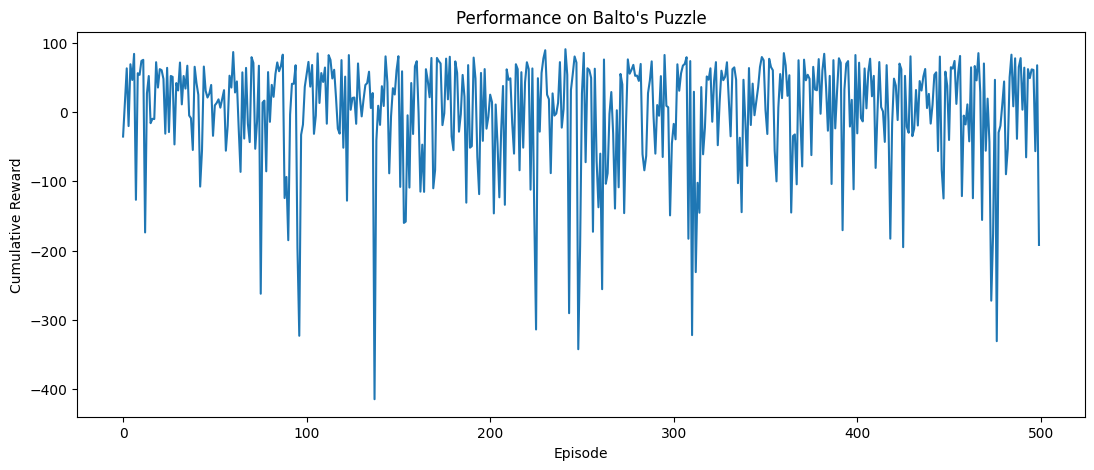

In [14]:
rewards = []
for episode in range(500):
    obs = env.reset()
    cumulative_reward = 0
    while True:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        cumulative_reward += reward
        if done:
            break
    rewards.append(cumulative_reward)
plt.figure(figsize=(13, 5))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Performance on Balto's Puzzle")
plt.show()

In [15]:
def evaluate_agent(env, agent, num_episodes=100):
    total_reward = 0         #initialize total reward to 0
    success_count = 0        #same as here
    total_steps = 0

    for _ in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done:
            action, _ = agent.predict(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward
            steps += 1

        total_reward += episode_reward
        total_steps += steps
        if done and reward == 100:  # Assuming 100 is the goal reward
            success_count += 1

    avg_reward = total_reward / num_episodes
    success_rate = success_count / num_episodes
    avg_steps = total_steps / success_count if success_count > 0 else float('inf')

    return avg_reward, success_rate, avg_steps

# Example usage - Replace 'agent' with 'model'
avg_reward, success_rate, avg_steps = evaluate_agent(env, model)  # Use 'model' instead of 'agent'
print(f"Average Reward: {avg_reward}")
print(f"Success Rate: {success_rate * 100:.2f}%")
print(f"Average Steps to Goal: {avg_steps}")

Average Reward: [5.2840977]
Success Rate: 100.00%
Average Steps to Goal: 70.06
